Nombre de bits démodulés : 96
Nombre de bits après décodage Manchester : 48
Message final décodé : dd


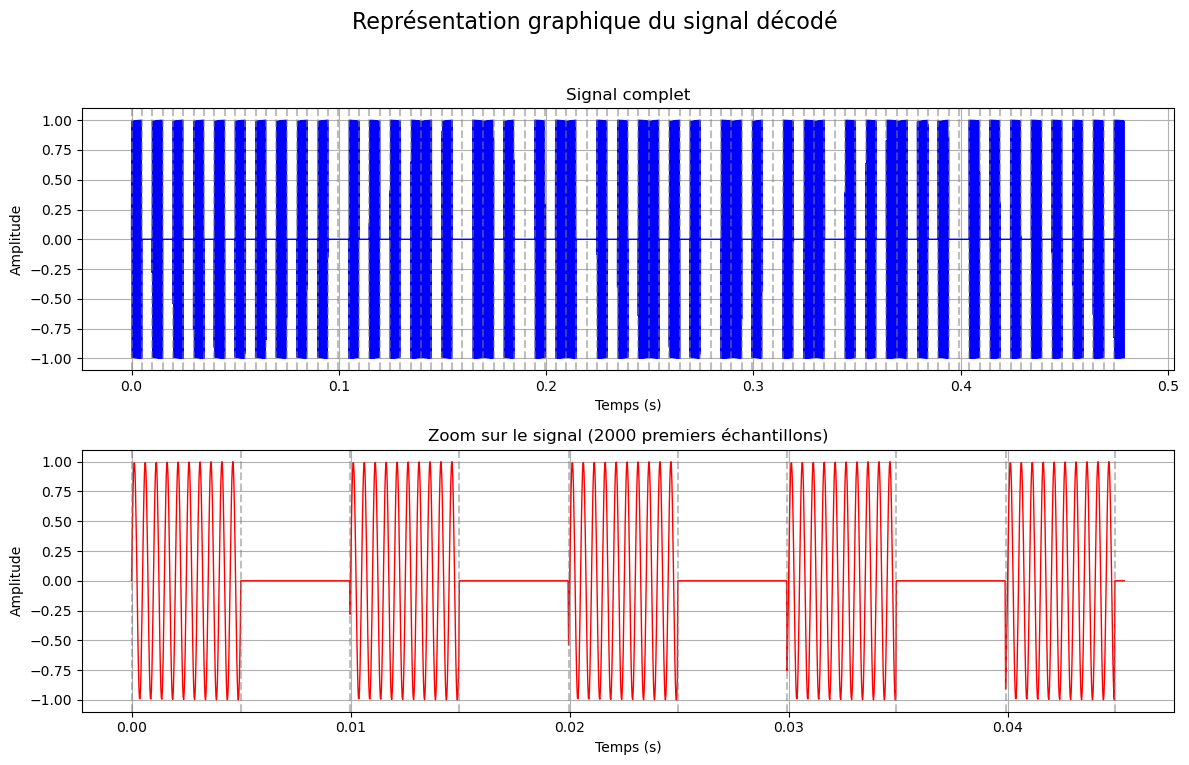

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
import os

###############################################################################
#                   PARAMÈTRES GLOBAUX
###############################################################################
Fe   = 44100        # Fréquence d'échantillonnage (Hz)
baud = 200          # Débit binaire (bits/s)
Ns   = int(Fe/baud) # Nombre d'échantillons par bit (~220)
Fp_ASK = 2000       # Fréquence de la porteuse ASK

###############################################################################
#             FONCTIONS DE DÉMODULATION & DÉCODAGE
###############################################################################

def demodulate_signal(signal, Fe_used):
    """
    Démodule un signal ASK.
    
    - signal : vecteur contenant le signal (supposé déjà normalisé en flottant)
    - Fe_used : fréquence d'échantillonnage utilisée
    
    Pour chaque bit (Ns échantillons), on multiplie par la porteuse et on intègre.
    Renvoie la liste des bits (1 ou 0).
    """
    N = len(signal)
    t = np.arange(N) / Fe_used
    # Génération de la porteuse ASK
    porteuse = np.sin(2 * np.pi * Fp_ASK * t)
    produit  = signal * porteuse
    bits = []
    for i in range(0, N, Ns):
        portion = produit[i:i+Ns]
        # Intégration par trapèze
        val = np.trapz(portion)
        bits.append(1 if val > 0 else 0)
    return bits

def Manchester_decode(bits):
    """
    Décodage Manchester : pour chaque paire, (1,0) -> 1 et (0,1) -> 0.
    Si le motif n'est pas reconnu, le bit est ignoré.
    """
    decode = []
    for i in range(0, len(bits), 2):
        if i+1 >= len(bits):
            break
        b1, b2 = bits[i], bits[i+1]
        if (b1, b2) == (1, 0):
            decode.append(1)
        elif (b1, b2) == (0, 1):
            decode.append(0)
    return decode

def trame_reception(bits):
    """
    Extrait la trame :
      - Fanion de début : 11111111
      - Octet de protocole (exemple : 11000011 pour 'txt')
      - Données + CRC
      - Fanion de fin : 00000000

    Renvoie (data_crc, type_fic) ou (None, None) en cas d'erreur.
    """
    if len(bits) < 16:
        return None, None
    fanion_debut = bits[:8]
    fanion_fin   = bits[-8:]
    core = bits[8:-8]
    
    if fanion_debut != [1]*8 or fanion_fin != [0]*8:
        return None, None
    
    if len(core) < 8:
        return None, None
    
    protocole = core[:8]
    data_crc  = core[8:]
    type_fic = "txt" if protocole == [1,1,0,0,0,0,1,1] else "?"
    return data_crc, type_fic

def crcreception(bits):
    """
    Vérifie le CRC sur des blocs de 12 bits (8 data + 4 CRC).
    Utilise le diviseur binaire '1001'.
    
    Renvoie la séquence de données (sans CRC) si l'intégrité est validée,
    sinon renvoie None.
    """
    diviseur = int("1001", 2)
    idx = 0
    data_res = []
    integrite_ok = True
    while idx + 12 <= len(bits):
        bloc = bits[idx:idx+12]
        idx += 12
        data_8 = bloc[:8]
        reste_4 = bloc[8:]
        # Recalcul du CRC
        data_str = ''.join(map(str, data_8))
        data_plus_0000 = data_str + "0000"
        data_dec = int(data_plus_0000, 2)
        reste_calc = data_dec % diviseur
        reste_str  = format(reste_calc, '04b')
        recu_str   = ''.join(map(str, reste_4))
        if reste_str != recu_str:
            integrite_ok = False
        data_res.extend(data_8)
    return data_res if integrite_ok else None

def ASCII_decode(bits, type_fic):
    """
    Convertit une séquence d'octets (8 bits) en chaîne ASCII.
    Si le protocole n'est pas reconnu ou si la séquence est vide, renvoie un message d'erreur.
    """
    if type_fic != "txt" or not bits:
        return "[Protocole inconnu ou bits vides]"
    chaine = ""
    for i in range(0, len(bits), 8):
        octet = bits[i:i+8]
        if len(octet) < 8:
            break
        val = int(''.join(map(str, octet)), 2)
        chaine += chr(val)
    return chaine

###############################################################################
#                  FONCTION DE DÉCODAGE DU FICHIER
###############################################################################

def decode_file(filename):
    """
    Lit le fichier (CSV ou WAV) selon son extension, démodule et décode le message.
    On suppose que le signal correspond au canal ASK.
    """
    # Vérifier que le fichier existe
    if not os.path.isfile(filename):
        print(f"Le fichier '{filename}' n'existe pas.")
        return

    ext = os.path.splitext(filename)[1].lower()
    
    if ext == '.csv':
        # Lecture depuis un fichier CSV (séparateur virgule)
        try:
            signal = np.genfromtxt(filename, delimiter=',')
            # S'assurer que le signal est unidimensionnel
            if signal.ndim > 1:
                signal = signal.flatten()
        except Exception as e:
            print(f"Erreur lors de la lecture du CSV : {e}")
            return
        Fe_used = Fe  # Utilisation de la fréquence globale
    elif ext == '.wav':
        # Lecture depuis un fichier WAV
        try:
            Fe_used, data = read(filename)
            # Si le signal est stéréo, on prend le canal gauche
            if data.ndim > 1 and data.shape[1] >= 1:
                signal = data[:, 0].astype(np.float32)
            else:
                signal = data.astype(np.float32)
        except Exception as e:
            print(f"Erreur lors de la lecture du WAV : {e}")
            return
    else:
        print("Extension non reconnue. Utilisez un fichier CSV ou WAV.")
        return

    # Démodulation du signal ASK
    bits_demod = demodulate_signal(signal, Fe_used)
    print(f"Nombre de bits démodulés : {len(bits_demod)}")
    
    # Décodage Manchester : récupération d'un bit par paire
    bits_manch = Manchester_decode(bits_demod)
    print(f"Nombre de bits après décodage Manchester : {len(bits_manch)}")
    
    # Extraction de la trame (fanions, protocole, données+CRC)
    data_crc, type_fic = trame_reception(bits_manch)
    if data_crc is None or type_fic is None:
        print("Erreur : la trame n'a pas pu être extraite (fanions incorrects).")
        return
    
    # Vérification CRC
    data_ok = crcreception(data_crc)
    if data_ok is None:
        print("Erreur : le CRC ne correspond pas, message corrompu.")
        return
    
    # Décodage ASCII
    message = ASCII_decode(data_ok, type_fic)
    print("Message final décodé :", message)
    
    # Représentation graphique améliorée
    try:
        N = len(signal)
        t = np.arange(N) / Fe_used

        fig, axs = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle("Représentation graphique du signal décodé", fontsize=16)

        # Graphique du signal complet
        axs[0].plot(t, signal, color='blue', lw=1)
        axs[0].set_title("Signal complet")
        axs[0].set_xlabel("Temps (s)")
        axs[0].set_ylabel("Amplitude")
        axs[0].grid(True)
        # Affichage des positions de début de bit
        for i in range(0, N, Ns):
            axs[0].axvline(x=i/Fe_used, color='gray', linestyle='--', alpha=0.5)
        
        # Graphique zoomé sur une portion du signal (par exemple, les 2000 premiers échantillons)
        zoom_samples = min(2000, N)
        t_zoom = t[:zoom_samples]
        axs[1].plot(t_zoom, signal[:zoom_samples], color='red', lw=1)
        axs[1].set_title("Zoom sur le signal ({} premiers échantillons)".format(zoom_samples))
        axs[1].set_xlabel("Temps (s)")
        axs[1].set_ylabel("Amplitude")
        axs[1].grid(True)
        # Affichage des positions de début de bit sur le zoom
        for i in range(0, zoom_samples, Ns):
            axs[1].axvline(x=i/Fe_used, color='gray', linestyle='--', alpha=0.5)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    except Exception as e:
        print("Erreur lors de l'affichage du signal :", e)

# Pour exécuter la fonction dans votre Notebook, définissez simplement le nom ou le chemin de votre fichier,
# puis appelez la fonction decode_file().
filename = input("Entrez le nom du fichier (ex: Message_ASK.wav ou Message_FSK.wavK) : ")
decode_file(filename)
